#Training CNN on CIFAR10 Dataset

We begin with building a CNN architecture for image classification task on CIFAR10 dataset.

In this first part of the tutorial, we will understand how to arrange the different architectural components of CNN network, defining the appropriate loss, training the network using backpropagation and finally testing it on the test data.To make data loading simple, we would use the torchvision package created as part of PyTorch which has data loaders for standard datasets such as ImageNet, CIFAR10, MNIST.

###CIFAR10 dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. (ref: https://www.cs.toronto.edu/~kriz/cifar.html)

Here are the classes in the dataset, as well as 10 random images from each:

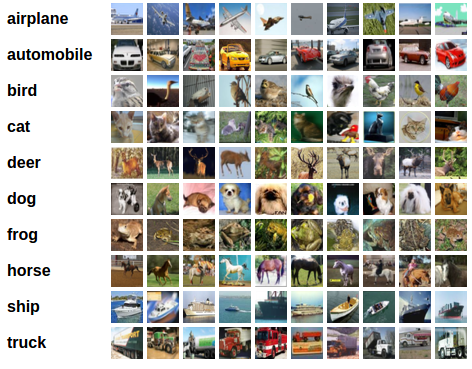

###Required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"torch version: {torch.__version__} using {device}")

torch version: 2.6.0+cu124 using cuda


##Dataset

For efficient training, we need to make sure that our code is efficient enough to send data from RAM to GPU and vice-versa. For some standard datasets like MNIST, CIFAR-10 etc., we already have some well structured dataloaders. In this tutorial, we will be using the CIFAR-10 dataloader available with `torchvision` library.

For more, you can visit the following links:
- Existing dataloaders:
  1. https://pytorch.org/vision/stable/datasets.html
  2. https://pytorch.org/docs/stable/data.html
- How to write custom dataloaders for your own dataset:
  1. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
  2. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the batch size for training
batch_size = 4

In [3]:
# We can perform different data augmentation
# techniques to increase the size of the dataset
# and make your model more robust

# Define transforms for data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
      )
])

# Define transforms for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
      )
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
  )
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True, num_workers=2
  )

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
  )
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
  )

# Define classes for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
NUM_CLASSES = len(classes)

100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s]


###Visualizing the dataset
Let us now visualize some of the training images from the CIFAR10 dataset

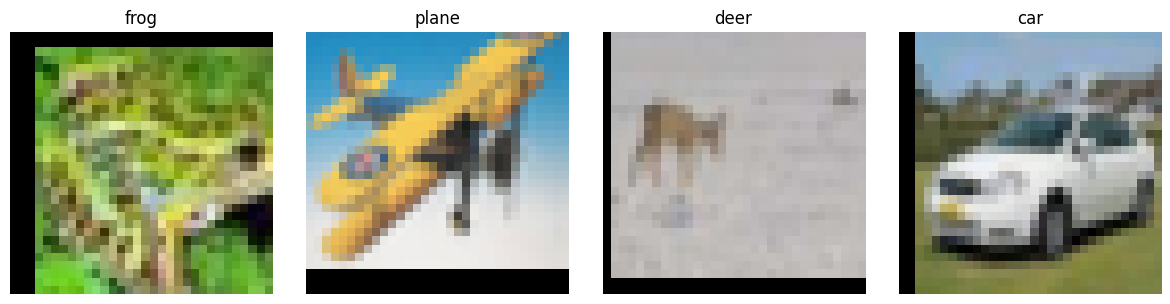

In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Visualize the first 4 images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    # Denormalize the image
    img = images[i] / 2 + 0.5
    img = img.numpy()

    # Transpose the image from (C, H, W) to (H, W, C) for visualization
    img = np.transpose(img, (1, 2, 0))

    # Plot the image
    axes[i].imshow(img)
    axes[i].set_title(classes[labels[i]])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

##Convolutional Neural Networks

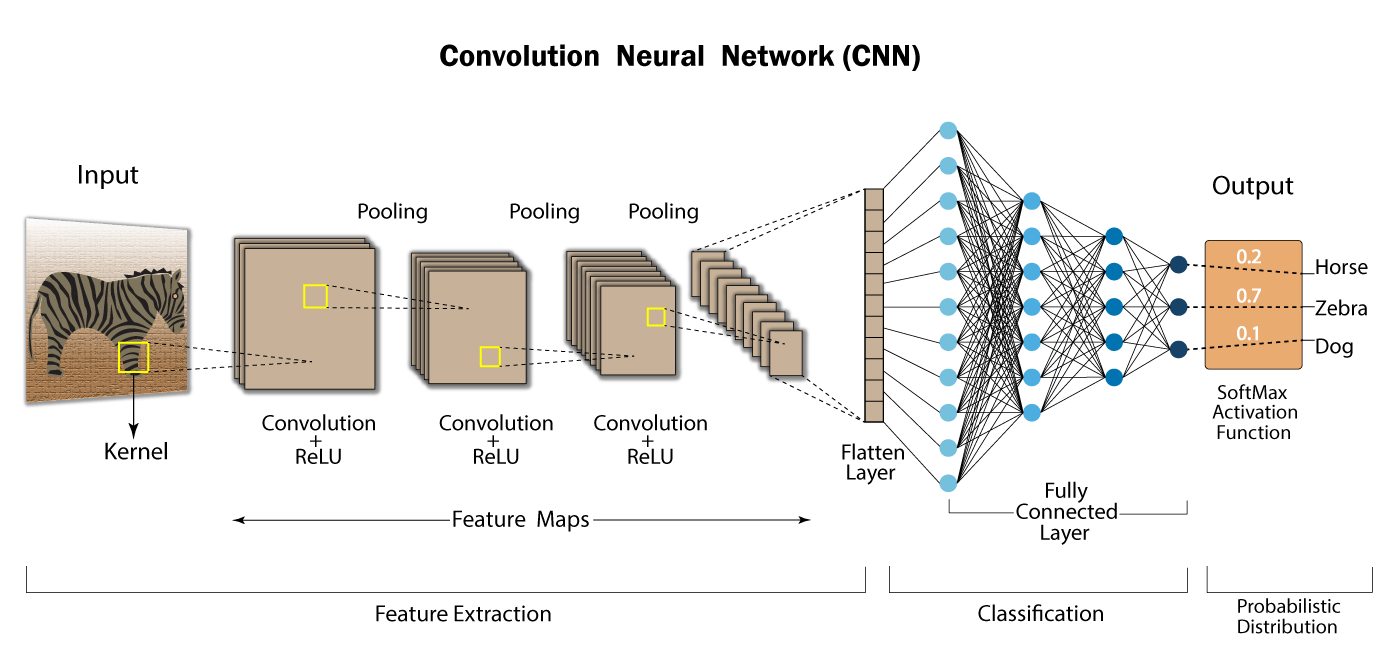

###Define a Convolutional Neural Network

To create a network, we should first inhert the base class `nn.Module`. We just need to define the `forward` function. The `backward` function (where gradients are computed) is automatically defined/computed for us using autograd. You can use any of the Tensor operations in the forward function.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=6,
            kernel_size=5,
            stride=1,         # default
            padding=0,        # default
            bias=True         # default
          )
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
          )
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5
          )
        self.fc1 = nn.Linear(
            in_features=16 * 5 * 5,
            out_features=120,
            bias=True           # default
          )
        self.fc2 = nn.Linear(
            in_features=120,
            out_features=84
          )
        self.fc3 = nn.Linear(
            in_features=84,
            out_features=NUM_CLASSES
          )

        ## Initialize weights (optional - by default Pytorch uses "Kaiming Uniform" initialization)
        ## More info: https://pytorch.org/docs/stable/nn.init.html
        # nn.init.kaiming_uniform_(self.conv1.weight)
        # nn.init.kaiming_uniform_(self.conv1.bias)
        ## repeat for all other conv layers
        # nn.init.kaiming_uniform_(self.fc1.weight)
        # nn.init.kaiming_uniform_(self.fc1.bias)
        ## repeat for all other linear layers


    def forward(self, x):
        # layer 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # layer 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # fc1 layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        # fc2 layer
        x = self.fc2(x)
        x = self.relu(x)
        # fc3 layer
        x = self.fc3(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


###Printing the parameter values


In [6]:
params = list(net.parameters())
print(f"Parameter size for first conv layer: {params[0].shape}")

Parameter size for first conv layer: torch.Size([6, 3, 5, 5])


###Define a loss function and an optimzier

We define the loss (criterion) to be cross entropy loss. We define our optimizer as SGD with momentum. Notice the choice of hyperparameters here.

In [7]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
learning_rate = 0.001
u = 0.9 # momentum
w_d = 0 # weight decay (weight decay is same as L2 regularization)

optimizer = torch.optim.SGD(
    net.parameters(),
    lr=learning_rate,
    momentum=u,
    weight_decay=w_d
  )

# Decay LR by a factor of 0.1 on every epoch
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)


###Train the network

Now, we will be training the network defined above on CIFAR-10 dataset.

We will train the network for num_epoch times (defined above)
- We fetch a batch of images and labels from dataloader
- We feed it to CNN network for forward pass
- Based on the output of forward pass, we calculate loss/error
- Then we calculate gradients of loss w.r.t. the parameters of the network
- Finally, we update the parameters based on the gradients using Gradient Descent algorithm




In [8]:
# Function for training the model
def train(net, trainloader, criterion, optimizer):
    # Set the network to training mode
    net.train()

    # Initialize statistics
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    for inputs, labels in trainloader:
        # Trasnfer input and labels to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate training accuracy
    train_accuracy = 100.0 * train_correct / train_total
    return train_loss/train_total, train_accuracy

In [9]:
# Function for validating the model
def validate(net, testloader, criterion):
    # Set the network to eval mode
    net.eval()

    # Initialize the statistics for validation
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            # Transfer inputs and labels to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Update statistics
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate validation accuracy
    val_accuracy = 100.0 * val_correct / val_total
    return val_loss/val_total, val_accuracy

In [10]:
# Set the number of training epochs
num_epochs = 10

# Lists to store training and validation accuracies
train_acc_list = []
val_acc_list = []

# Training loop
for epoch in range(num_epochs):
  train_loss, train_accuracy = train(net, trainloader, criterion, optimizer)
  val_loss, val_accuracy = validate(net, testloader, criterion)

  # Decay the learning rate
  # exp_lr_scheduler.step()

  train_acc_list.append(train_accuracy)
  val_acc_list.append(val_accuracy)

  print(f"Epoch [{epoch+1}/{num_epochs}], "
      f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
      f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/10], Train Loss: 0.4506, Train Accuracy: 32.72%, Val Loss: 0.3763, Val Accuracy: 44.33%
Epoch [2/10], Train Loss: 0.3787, Train Accuracy: 44.59%, Val Loss: 0.3445, Val Accuracy: 50.02%
Epoch [3/10], Train Loss: 0.3548, Train Accuracy: 48.69%, Val Loss: 0.3251, Val Accuracy: 52.78%
Epoch [4/10], Train Loss: 0.3361, Train Accuracy: 51.47%, Val Loss: 0.3116, Val Accuracy: 55.95%
Epoch [5/10], Train Loss: 0.3261, Train Accuracy: 53.13%, Val Loss: 0.2927, Val Accuracy: 58.08%
Epoch [6/10], Train Loss: 0.3166, Train Accuracy: 54.94%, Val Loss: 0.2913, Val Accuracy: 58.16%
Epoch [7/10], Train Loss: 0.3066, Train Accuracy: 56.33%, Val Loss: 0.2826, Val Accuracy: 59.99%
Epoch [8/10], Train Loss: 0.3012, Train Accuracy: 57.11%, Val Loss: 0.2819, Val Accuracy: 60.10%
Epoch [9/10], Train Loss: 0.2955, Train Accuracy: 58.19%, Val Loss: 0.2725, Val Accuracy: 61.33%
Epoch [10/10], Train Loss: 0.2918, Train Accuracy: 58.82%, Val Loss: 0.2784, Val Accuracy: 61.52%


###Plot the training and validation curve

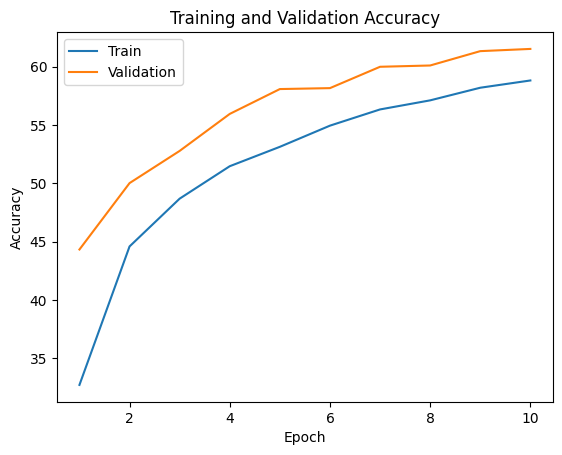

In [11]:
# Plot the training and validation curves
plt.figure()
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train')
plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

##Excercise

1. Try changing the batch size and check the effect on accuracy, convergence and training time. (hint: Try in range of `[1, 10000]`)
2. Try changing the learning rate and momentum. Check the effect of changing learning rate on accuracy, convergence and training time. (hint: Try learning rate in range `[0.0001, 10]`)
3. Try increasing the number of epochs. Check whether the network converges or overfits or underfits.
4. Try adding two more convolutional layers and check the performance.
5. Change the optimizer and check the performance and convergence. (hint: Try using _Adagrad_, _Adam_, _Adadelta_, _RMSProp_;
`optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=w_d)` )
6. Modify the loss to `MSELoss` and check the accuracy. (hint: `criterion = nn.MSELoss()`)
7. Modify the weight initialization scheme to _uniform_, _normal_, _ones_, _zeros_ and observe the convergence. (hint: `nn.init.ones_(self.conv1.weight)`; https://pytorch.org/docs/stable/nn.init.html)
8. Try a combination of these to get the best possible accuracy.

###Batch Normalization and Dropout
We will now introduce _batch normalization_ and _dropout_ to the CNN architecture, and check its performance.

**Dropout**: Dropout is a regularization technique in deep neural networks where randomly selected neurons are ignored or "dropped out" during training, reducing co-adaptation of neurons and preventing overfitting. It helps improve the generalization and robustness of the model by reducing the reliance on specific neurons and encourages the network to learn more robust features.

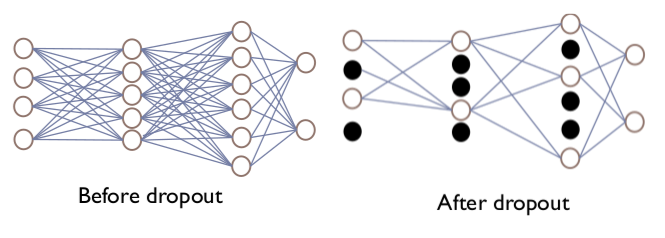

**BatchNorm**: Batch normalization is a technique used in deep neural networks to normalize the activations of each layer by subtracting the batch mean and dividing by the batch standard deviation, making the network more robust to parameter initialization and reducing internal covariate shift. It helps stabilize and speed up the training process by normalizing the inputs to each layer, improving gradient flow and enabling higher learning rates.

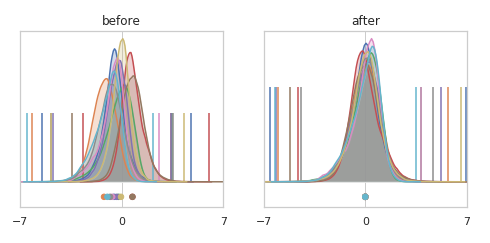

In [12]:
class Net_DB(nn.Module):
    def __init__(self):
        super(Net_DB, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv1_bn = nn.BatchNorm2d(num_features=6)     # Batch Norm Layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, NUM_CLASSES)

        # Flag to apply dropouts only at training
        self.is_training = False


    def forward(self, x):
        # layer 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv1_bn(x)
        x = self.maxpool(x)
        # layer 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # fc1 layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = F.dropout(x, p=0.2, training=self.is_training)
        # fc2 layer
        x = self.fc2(x)
        x = self.relu(x)
        # fc3 layer
        x = self.fc3(x)
        return x


net_db = Net_DB().to(device)
print(net_db)

Net_DB(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Train the model

In [13]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
learning_rate = 0.001
u = 0.9 # momentum
w_d = 0 # weight decay (weight decay is same as L2 regularization)

optimizer = torch.optim.SGD(
    net_db.parameters(),
    lr=learning_rate,
    momentum=u,
    weight_decay=w_d
  )

# Set the number of training epochs
num_epochs = 10

# Lists to store training and validation accuracies
train_acc_list = []
val_acc_list = []

# Training loop
for epoch in range(num_epochs):
  # Training
  net_db.is_training = True
  train_loss, train_accuracy = train(net_db, trainloader, criterion, optimizer)
  # Validation
  net_db.is_training = False
  val_loss, val_accuracy = validate(net_db, testloader, criterion)

  train_acc_list.append(train_accuracy)
  val_acc_list.append(val_accuracy)

  print(f"Epoch [{epoch+1}/{num_epochs}], "
      f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
      f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/10], Train Loss: 0.4462, Train Accuracy: 34.06%, Val Loss: 0.3585, Val Accuracy: 47.22%
Epoch [2/10], Train Loss: 0.3840, Train Accuracy: 44.32%, Val Loss: 0.3277, Val Accuracy: 54.15%
Epoch [3/10], Train Loss: 0.3593, Train Accuracy: 48.28%, Val Loss: 0.3184, Val Accuracy: 54.88%
Epoch [4/10], Train Loss: 0.3443, Train Accuracy: 51.01%, Val Loss: 0.3048, Val Accuracy: 56.32%
Epoch [5/10], Train Loss: 0.3351, Train Accuracy: 52.24%, Val Loss: 0.2959, Val Accuracy: 58.51%
Epoch [6/10], Train Loss: 0.3290, Train Accuracy: 53.20%, Val Loss: 0.2800, Val Accuracy: 60.58%
Epoch [7/10], Train Loss: 0.3231, Train Accuracy: 54.12%, Val Loss: 0.2828, Val Accuracy: 60.60%
Epoch [8/10], Train Loss: 0.3191, Train Accuracy: 54.60%, Val Loss: 0.2851, Val Accuracy: 59.86%
Epoch [9/10], Train Loss: 0.3148, Train Accuracy: 55.09%, Val Loss: 0.2739, Val Accuracy: 61.84%
Epoch [10/10], Train Loss: 0.3129, Train Accuracy: 55.15%, Val Loss: 0.2660, Val Accuracy: 63.17%


Plot the training and validation curve

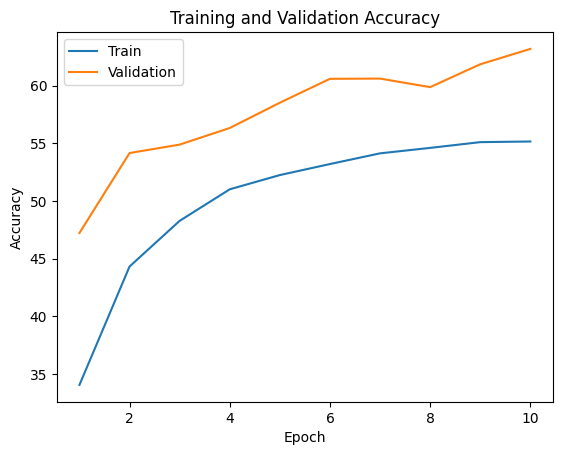

In [14]:
# Plot the training and validation curves
plt.figure()
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train')
plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

###Residual Networks
We will now implement a resnet block and use it as one the block for training CNN on CIFAR10 dataset. The residual module is shown as below:

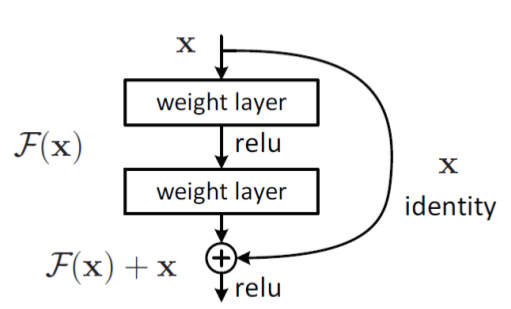

A simple residual block

In [15]:
# Definition of basic residual block which would be replicated

class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

        ### Batch normalization
        self.bn1 = nn.BatchNorm2d(planes)
        ###

        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        #adding the skip connection
        out += residual
        out = self.relu(out)

        return out

A resnet model that uses residual block

In [16]:
#Defining the entire CNN architecture using multiple resnet modules

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.input_channels = 64
        super(ResNet, self).__init__()

        #Initial non-resnet layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False) # input ch = 3, output ch = 64
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #Creating the resnet modules
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.fc = nn.Linear(4096, num_classes)

    #Duplicating the resnet module
    def _make_layer(self, block, target_output_channels, blocks, stride=1):
        layers = []
        self.input_channels = target_output_channels
        for i in range(0, blocks):
            layers.append(block(self.input_channels, target_output_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        #attaching the resnet modules
        x = self.layer1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

Create a model

In [17]:
res_model = ResNet(BasicBlock, [2]).to(device)
print(res_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Define the loss and optimizer

In [18]:
# Defining the loss function
criterion = nn.CrossEntropyLoss()

#Using adam optimizer
optimizer = torch.optim.Adam(res_model.parameters(), lr = 0.0001)

Train the resnet model

In [19]:
# Set the number of training epochs
num_epochs = 10

# Lists to store training and validation accuracies
train_acc_list = []
val_acc_list = []

# Training loop
for epoch in range(num_epochs):
  # Training
  train_loss, train_accuracy = train(res_model, trainloader, criterion, optimizer)
  # Validation
  val_loss, val_accuracy = validate(res_model, testloader, criterion)

  train_acc_list.append(train_accuracy)
  val_acc_list.append(val_accuracy)

  print(f"Epoch [{epoch+1}/{num_epochs}], "
      f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
      f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/10], Train Loss: 0.4024, Train Accuracy: 43.32%, Val Loss: 0.2792, Val Accuracy: 60.59%
Epoch [2/10], Train Loss: 0.3167, Train Accuracy: 55.26%, Val Loss: 0.2533, Val Accuracy: 65.12%
Epoch [3/10], Train Loss: 0.2814, Train Accuracy: 60.38%, Val Loss: 0.2349, Val Accuracy: 67.19%
Epoch [4/10], Train Loss: 0.2560, Train Accuracy: 64.05%, Val Loss: 0.2156, Val Accuracy: 70.76%
Epoch [5/10], Train Loss: 0.2400, Train Accuracy: 66.22%, Val Loss: 0.2299, Val Accuracy: 68.93%
Epoch [6/10], Train Loss: 0.2266, Train Accuracy: 68.27%, Val Loss: 0.2120, Val Accuracy: 71.37%
Epoch [7/10], Train Loss: 0.2146, Train Accuracy: 69.89%, Val Loss: 0.1973, Val Accuracy: 72.44%
Epoch [8/10], Train Loss: 0.2052, Train Accuracy: 71.35%, Val Loss: 0.1923, Val Accuracy: 73.66%
Epoch [9/10], Train Loss: 0.1974, Train Accuracy: 72.40%, Val Loss: 0.1799, Val Accuracy: 75.52%
Epoch [10/10], Train Loss: 0.1908, Train Accuracy: 73.28%, Val Loss: 0.1819, Val Accuracy: 75.74%


Plot the training and validation curve

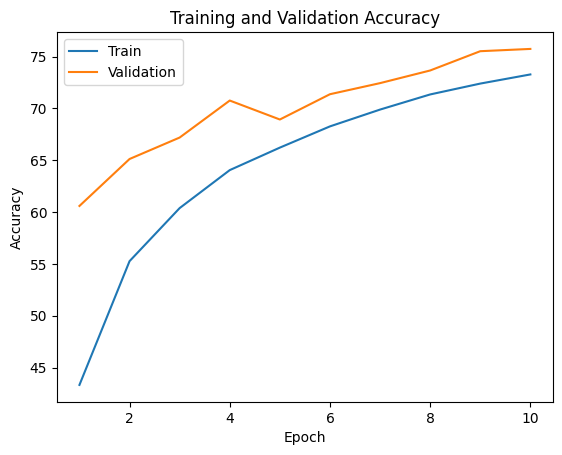

In [20]:
# Plot the training and validation curves
plt.figure()
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train')
plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

###Excercise
1. Add multiple resnet modules and verify the performance in CIFAR dataset.
2. Create a bottleneck based ResNet module shown below and validate the training performance.

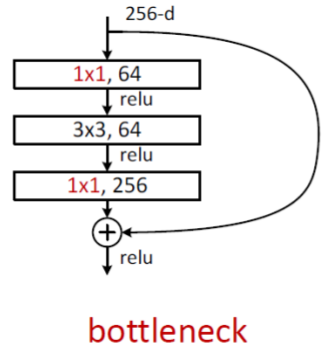